# CSE 152: Intro to Computer Vision - Spring 2019 Assignment 2
## Instructor: David Kriegman
### Assignment published on Friday, April 26, 2019
### Due on Wednesday, May 8, 2019 at 11:59pm

## Instructions
* This assignment must be completed individually. Review the academic integrity and collaboration policies on the course website.
* All solutions should be written in this notebook.
* If you want to modify the skeleton code, you may do so. It has been merely been provided as a framework for your solution.
* You may use Python packages for basic linear algebra (e.g. NumPy or SciPy for basic operations), but you may not use packages that directly solve the problem. If you are unsure about using a specific package or function, ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as an `.ipynb` file. Submit both files (`.pdf` and `.ipynb`) on Gradescope. **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy:** a penalty of 10% per day after the due date.

---

## Problem 1: Stereo and Disparity [3 pts]
Consider two cameras whose (virtual) image planes are the z=1 plane, and whose focal points are at (-20, 0, 0) and (20, 0, 0). We''ll call a point in the first camera (x, y), and a point in the second camera (u, v). Points in each camera are relative to the camera center. So, for example if (x, y) = (0, 0), this is really the point (-20, 0, 1) in world coordinates, while if (u, v) = (0, 0) this is the point (20, 0, 1).![Fig1.png](fig/fig1.png)
a) Suppose the points (x, y) = (12, 12) is matched to the point (u, v) = (1, 12). What is the 3D location of this point?

b) Consider points that lie on the line x + z = 0, y = 0. Use the same stereo setup as before. Write an analytic expression giving the disparity of a point on this line after it projects onto the two images, as a function of its position in the right image. So your expression should only involve the variables u and d (for disparity). Your expression only needs to be valid for points on the line that are in front of the cameras, i.e. with z > 1.

## Problem 2: Sparse Stereo Matching [20 pts]

In this problem we will play around with sparse stereo matching methods. You will work on two image pairs, a warrior figure and a figure from the Matrix movies. These files both contain two images, two camera matrices, and associated sets of corresponding points (extracted by manually clicking the images). 

For the problems below, you will complete functions to demonstrate results on warrior image pairs (warrior1.png, warrior2.png). In all cases, you should apply the same procedures on the matrix image pair (matrix1.png, matrix2.png) as well. (Provide the same thing for BOTH matrix and warrior.) Note that the matrix image pair is harder, in the sense that matching algorithms will not work quite as well on it. You should expect good results, however, on warrior.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [2]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# convert points from euclidean to homogeneous
def to_homog(points):
    points = np.concatenate((points, np.ones((1, points.shape[1]))), axis=0)
    return points

# convert points from homogeneous to euclidean
def from_homog(points_homog):
    z = points_homog[-1,:]
    points_homog = points_homog[:2,:]/z
    return points_homog

In [71]:
# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.show()

### Epipolar Geometry 

Using the fundamental_matrix function and the corresponding points provided in cor1.npy and cor2.npy, calculate the fundamental matrix. Note that estimation of the fundamental matrix is ill-conditioned; we need to normalize coordinates before computing the fundamental matrix in order to remedy this problem. The fundamental_matrix function contains code for normalization, so you just need to complete the compute_fundamental function by implementing the eight-point algorithm.

Next, use this fundamental matrix, implement plot_epipolar_lines to plot the epipolar lines in both image pairs. For this part you may want to complete the function compute_fundamental and then use plot_epipolar_lines to draw epipolar lines on both images. Below, we provide some example results on the dino image pair. Your results should look similar. Include your results for matrix and warrior as per the figure below. 
![Dino Epipolar](fig/dinoEpi1.png)
![Dino Epipolar](fig/dinoEpi2.png)

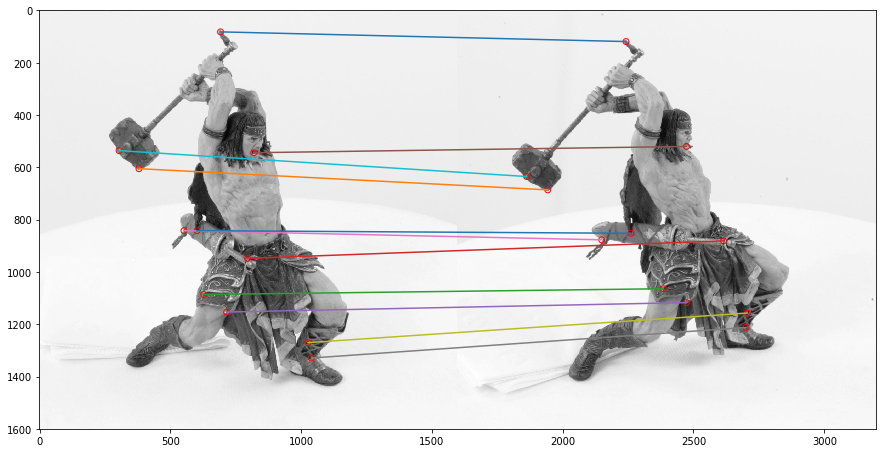

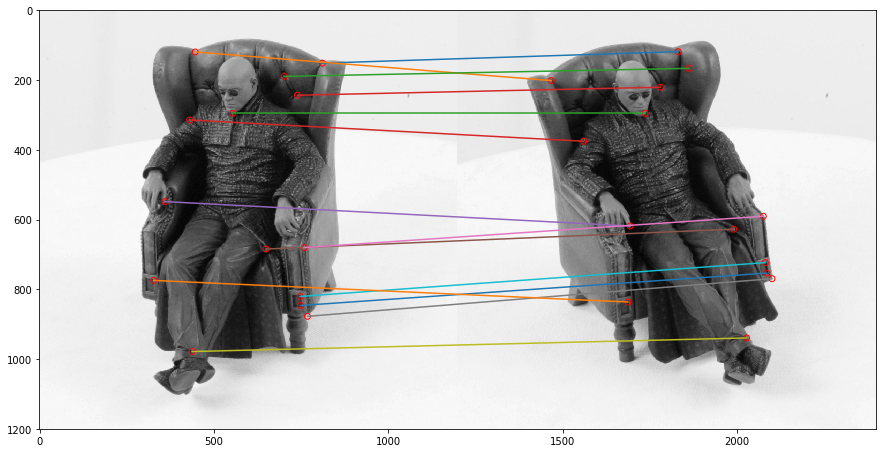

In [76]:
import numpy as np
import matplotlib.pyplot as plt

imgs = []
for i in range(2):
    img = io.imread('p4/warrior/warrior' + str(i) + '.png')
    #img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs.append(rgb2gray(img))
    
cor1 = np.load("./p4/warrior/cor1.npy")
cor2 = np.load("./p4/warrior/cor2.npy")
matching = [(cor1[:,i], cor2[:,i]) for i in range(cor1.shape[1])]    
show_matching_result(imgs[0],imgs[1], matching)

imgs = []
for i in range(2):
    img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    #img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs.append(rgb2gray(img))
    
cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")
matching = [(cor1[:,i], cor2[:,i]) for i in range(cor1.shape[1])]    
show_matching_result(imgs[0],imgs[1], matching)



# Remember to show your result for matrix image pair

### Compute the Fundamental Matrix [5 pts]
Please complete the compute_fundamental function. You only need to write the part between "Your Code Here!" and "Your Code End!"

In [5]:
def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x*x', x*y', x, y*x', y*y', y, x', y', 1] 
    """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    '''
    Your Code Here!
    '''
    
    # build matrix for equations
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ] 
    
    '''
    Your Code End!
    '''
        
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]


def fundamental_matrix(x1,x2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

### Epipolar Lines [5 pts]

In [6]:
def plot_epipolar_lines(F,img1,img2, cor1, cor2):
    """Plot epipolar lines on image given fundamental matrix, image, corners

    Args:
        F: Fundamental matrix
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """
    """
    Your Code Here !!!
    """
    abc_image1 = np.dot(F,cor2)
    abc_image2 = np.dot(F.T,cor1)
    
    cor1 = cor1/cor1[-1, :]
    cor2 = cor2/cor2[-1, :]
    
    plt.figure(figsize=(6,6))
    plt.imshow(img1, cmap = 'gray')
    for i in range(cor1.shape[1]):
        plt.scatter(cor1[0, i], cor1[1, i], facecolor = 'b')
        a = abc_image1[0]
        b = abc_image1[1]
        c = abc_image1[2]
        slope = (-1*a)/b;
        intercept = (-1 * c)/b;

        y1 = intercept
        y2 = slope*(img1.shape[1])+ intercept
        plt.plot([0, img1.shape[1]], [y1, y2], color = 'b')
        plt.axis([0, img1.shape[1], img1.shape[0], 0])
    plt.show()

    plt.figure(figsize=(6,6))
    plt.imshow(img2, cmap = 'gray')
    for i in range(cor1.shape[1]):
        plt.scatter(cor2[0, i], cor2[1, i], facecolor = 'b')
        a = abc_image2[0]
        b = abc_image2[1]
        c = abc_image2[2]
        slope = (-1*a)/b;
        intercept = (-1 * c)/b;
        y1 = intercept
        y2 = slope*(img2.shape[1])+ intercept
        plt.plot([0, img2.shape[1]], [y1, y2], color = 'b')
        plt.axis([0, img2.shape[1], img2.shape[0], 0])
    plt.show()
    
    

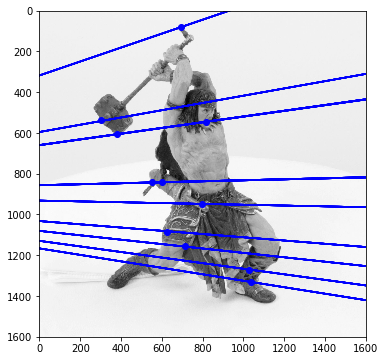

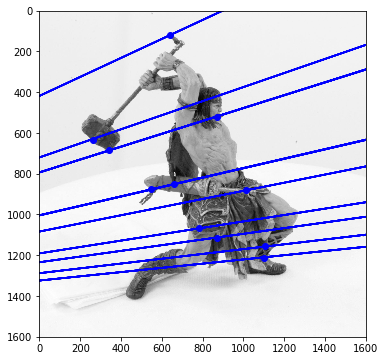

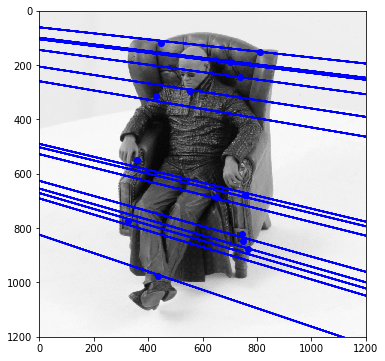

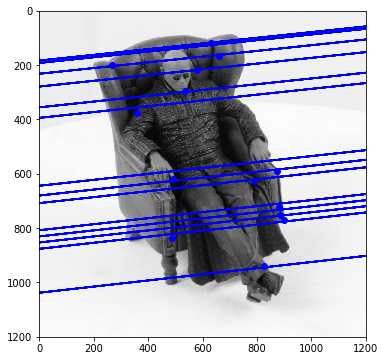

In [12]:
imgs = []
for i in range(2):
    img = io.imread('p4/warrior/warrior' + str(i) + '.png')
    #img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs.append(rgb2gray(img))
    
cor1 = np.load("./p4/warrior/cor1.npy")
cor2 = np.load("./p4/warrior/cor2.npy")
F = fundamental_matrix(cor1,cor2)
plot_epipolar_lines(F,imgs[0],imgs[1],cor1,cor2)

imgs = []
for i in range(2):
    img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    #img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs.append(rgb2gray(img))
    
cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")
F = fundamental_matrix(cor1,cor2)
plot_epipolar_lines(F,imgs[0],imgs[1],cor1,cor2)

### Image Rectification 
 An interesting case for epipolar geometry occurs when two images are parallel to each other. In this case, there is no rotation component involved between the two images and the essential matrix is $\texttt{E}=[\boldsymbol{T_{x}}]\boldsymbol{R}=[\boldsymbol{T_{x}}]$. Also if you observe the epipolar lines $\boldsymbol{l}$ and $\boldsymbol{l^{'}}$ for parallel images, they are horizontal and consequently, the corresponding epipolar lines share the same vertical coordinate. Therefore the process of making images parallel becomes useful while discerning the relationships between corresponding points in images.
 Rectifying a pair of images can also be done for uncalibrated camera images (i.e. we do not require the camera matrix of intrinsic parameters). Using the fundamental matrix we can find the pair of epipolar lines $\boldsymbol{l_i}$ and $\boldsymbol{l^{'}_i}$ for each of the correspondences. The intersection of these lines will give us the respective epipoles $\boldsymbol{e}$ and $\boldsymbol{e^{'}}$.  Now to make the epipolar lines to be parallel we need to map the epipoles to infinity. Hence, we need to find a homography that maps the epipoles to infinity. The method to find the homography has been implemented for you. You can read more about the method used to estimate the homography in the paper "Theory and Practice of Projective Rectification" by Richard Hartley.
 ![Image Rectification Setup](image_rectification.png)
 
 In this part you first need to complete the function compute_epipole. The function compute_epipole is used to calculate the epipoles for a given fundamental matrix and corner point correspondences in the two images.
 
 Using the compute_epipoles function and the given compute_matching_homographies function, we get $H_L$ and $H_R$. Then we can complete the function image_rectification to find the rectified images and plot the parallel epipolar lines using the plot_epipolar_lines function from above. You need to run this for both the matrix and the warrior images. A sample output is provided below:
 ![sample rectification](sample_rectification.png)

### Compute Epipole [5 pts]

In [54]:
def compute_epipole(F):
    '''
    This function computes the epipoles for a given fundamental matrix and corner point correspondences
    input:
    F--> Fundamental matrix
    output:
    e1--> corresponding epipole in image 1
    e2--> epipole in image2
    '''
    """
    Your Code Here!!!
    """
    e1 = np.linalg.svd(F.T)[-1]
    e2 = np.linalg.svd(F)[-1]
    e1 = e1[-1]
    e2 = e2[-1]
    return e1/e1[2], e2/e2[2]

F = fundamental_matrix(cor1, cor2)
e1, e2 = compute_epipole(F)
print(e1,e2)


(array([-1.69691257e+03,  8.97422748e+02,  1.00000000e+00]), array([-2.50388412e+03,  1.58326449e+03,  1.00000000e+00]))


### Image Rectification [5 pts]

In [94]:
def compute_matching_homographies(e2, F, im2, points1, points2):
    
    '''This function computes the homographies to get the rectified images
    input:
    e2--> epipole in image 2
    F--> the Fundamental matrix
    im2--> image2
    points1 --> corner points in image1
    points2--> corresponding corner points in image2
    output:
    H1--> Homography for image 1
    H2--> Homography for image 2
    '''
    # calculate H2
    width = im2.shape[1]
    height = im2.shape[0]

    T = np.identity(3)
    T[0][2] = -1.0 * width / 2
    T[1][2] = -1.0 * height / 2

    e = T.dot(e2)
    e1_prime = e[0]
    e2_prime = e[1]
    if e1_prime >= 0:
        alpha = 1.0
    else:
        alpha = -1.0

    R = np.identity(3)
    R[0][0] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[0][1] = alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][0] = - alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][1] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)

    f = R.dot(e)[0]
    G = np.identity(3)
    G[2][0] = - 1.0 / f

    H2 = np.linalg.inv(T).dot(G.dot(R.dot(T)))

    # calculate H1
    e_prime = np.zeros((3, 3))
    e_prime[0][1] = -e2[2]
    e_prime[0][2] = e2[1]
    e_prime[1][0] = e2[2]
    e_prime[1][2] = -e2[0]
    e_prime[2][0] = -e2[1]
    e_prime[2][1] = e2[0]

    v = np.array([1, 1, 1])
    M = e_prime.dot(F) + np.outer(e2, v)

    points1_hat = H2.dot(M.dot(points1.T)).T
    points2_hat = H2.dot(points2.T).T

    W = points1_hat / points1_hat[:, 2].reshape(-1, 1)
    b = (points2_hat / points2_hat[:, 2].reshape(-1, 1))[:, 0]

    # least square problem
    a1, a2, a3 = np.linalg.lstsq(W, b)[0]
    HA = np.identity(3)
    HA[0] = np.array([a1, a2, a3])

    H1 = HA.dot(H2).dot(M)
    return H1, H2

def target_dim(im,H):
    #x,y coordinates
    im1_shape = np.array([(im.shape[1],im.shape[0])])
    #origin
    origin =np.array([(0,0)])
    #boundary1
    im1_bound1 = np.array([(im.shape[1],0)])
    #boundary2
    im1_bound2 = np.array([(0,im.shape[0])])
    target_size_orig_one = from_homog(np.dot(H,to_homog(origin.T)))
    target_size_one = from_homog(np.dot(H,to_homog((im1_shape).T)))
    target_size_two = from_homog(np.dot(H,to_homog((im1_bound1).T)))
    target_size_three = from_homog(np.dot(H,to_homog((im1_bound2).T)))
    for i in range(0,2):
        target_size_orig_one[i]= int(target_size_orig_one[i])
        target_size_one[i]= int(target_size_one[i])
        target_size_two[i]= int(target_size_two[i])
        target_size_three[i]= int(target_size_three[i]) 
        
    min_x = np.min([target_size_one[0], target_size_orig_one[0],target_size_two[0],target_size_three[0]])
    min_y = np.min([target_size_one[1], target_size_orig_one[1],target_size_two[1],target_size_three[1]])
    max_x = np.max([target_size_one[0], target_size_orig_one[0],target_size_two[0],target_size_three[0]])
    max_y = np.max([target_size_one[1], target_size_orig_one[1],target_size_two[1],target_size_three[1]])

    return min_x,min_y,max_x,max_y
def image_rectification(im1,im2,points1,points2):
    '''This function provides the rectified images along with the new corner points as outputs for a given pair of 
    images with corner correspondences
    input:
    im1--> image1
    im2--> image2
    points1--> corner points in image1
    points2--> corner points in image2
    output:
    rectified_im1-->rectified image 1
    rectified_im2-->rectified image 2
    new_cor1--> new corners in the rectified image 1
    new_cor2--> new corners in the rectified image 2
    '''
    #apply transformation to the corners in figure 1and figure 2
    '''
    Your Code Here!!!
    '''
    new_cors_one = np.zeros(points1.shape)
    new_cors_two = np.zeros(points2.shape)
    F = fundamental_matrix(points1, points2)
    e1, e2 = compute_epipole(F)
    H1, H2 = compute_matching_homographies(e2, F.T, im2, points1.T, points2.T)
    for i in range(points1.shape[1]):
        new_cors_one[:,i]= np.dot(H1, points1[:,i])
    new_cors_one =  new_cors_one/new_cors_one[-1,:]
    
    for i in range(points2.shape[1]):
        new_cors_two[:,i]= np.dot(H2, points2[:,i])
    new_cors_two =  new_cors_two/new_cors_two[-1,:]

    min_x,min_y,max_x,max_y = target_dim(im1,H1)
    print("im1 x min max",min_x,max_x)
    print("im1 y min max",min_y,max_y)
    target_dim_one_x= int(max_x - min_x)
    target_dim_one_y= int(max_y - min_y)
    print("target dimensions im1",target_dim_one_x,target_dim_one_y)
    H1_inv = np.linalg.inv(H1)
    shape = np.array(([target_dim_one_y,target_dim_one_x]), dtype=int)
    rectified_ims_one = np.ones(shape)
    for i in range(0,target_dim_one_y):
        for j in range(0,target_dim_one_x):
            coor = from_homog(np.dot(H1_inv, to_homog(np.array([[j+min_x,i+min_y]]).T)))                  
            y = int(coor[1])
            x = int(coor[0])   
            if y < 0 or y >= im1.shape[0] or x < 0 or x >= im1.shape[1]:
                continue
            rectified_ims_one[i, j] = im1[y, x]
    
    new_cors_one[0,:]=  new_cors_one[0,:]- min_x
    new_cors_one[1,:]=  new_cors_one[1,:]- min_y
            

    min_x,min_y,max_x,max_y = target_dim(im2,H2)
    print("im2 x min max",min_x,max_x)
    print("im2 y min max",min_y,max_y)
    target_dim_two_x= int(max_x - min_x)
    target_dim_two_y= int(max_y - min_y)
    print("target dimensions im2",target_dim_two_x,target_dim_two_y)
    shape = np.array(([target_dim_two_y,target_dim_two_x]), dtype=int)
    
    H2_inv = np.linalg.inv(H2)
    rectified_ims_two = np.ones(shape)
    for i in range(0,target_dim_two_y):
        for j in range(0,target_dim_two_x):
            #coor = from_homog(np.dot(H2_inv, to_homog(np.array([[j+np.min(target_size_two[0], target_size_orig_two[0]),i+np.min(target_size_two[1], target_size_orig_two[1])]]).T)))
            coor = from_homog(np.dot(H2_inv, to_homog(np.array([[j+min_x,i+min_y]]).T)))
            y = int(coor[1])
            x = int(coor[0])   
            if y < 0 or y >= im2.shape[0] or x < 0 or x >= im2.shape[1]:
                continue
            rectified_ims_two[i, j] = im2[y, x]

    new_cors_two[0,:]=  new_cors_two[0,:]- min_x
    new_cors_two[1,:]=  new_cors_two[1,:]- min_y
    
    return rectified_ims_one,rectified_ims_two,new_cors_one,new_cors_two

/tmp/lpy/lib/python2.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


('im1 x min max', -481.0, 1539.0)
('im1 y min max', -309.0, 1855.0)
('target dimensions im1', 2020, 2164)
('im2 x min max', -544.0, 1550.0)
('im2 y min max', -367.0, 1628.0)
('target dimensions im2', 2094, 1995)


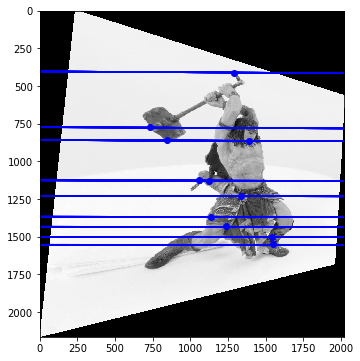

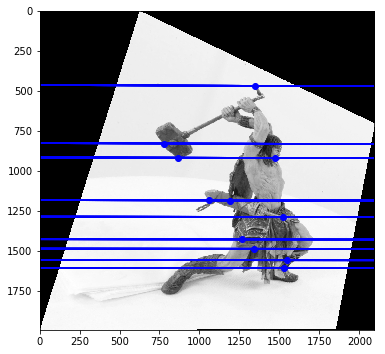

('im1 x min max', -196.0, 1310.0)
('im1 y min max', -44.0, 1342.0)
('target dimensions im1', 1506, 1386)
('im2 x min max', -57.0, 1265.0)
('im2 y min max', -58.0, 1265.0)
('target dimensions im2', 1322, 1323)


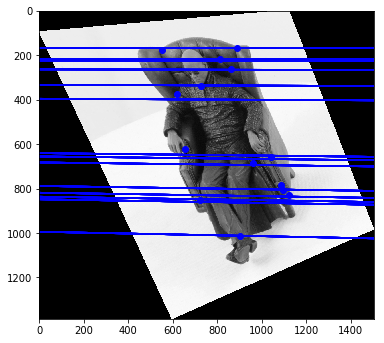

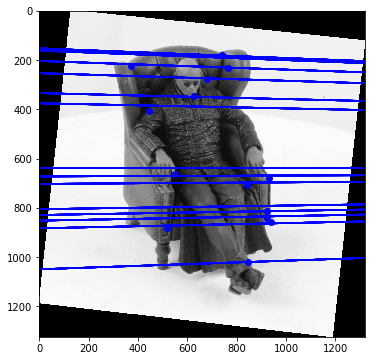

In [95]:
imgs = []
for i in range(2):
    img = io.imread('p4/warrior/warrior' + str(i) + '.png')
    #img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs.append(rgb2gray(img))
    
cor1 = np.load("./p4/warrior/cor1.npy")
cor2 = np.load("./p4/warrior/cor2.npy")
#F = fundamental_matrix(cor1,cor2)
#plot_epipolar_lines(F,imgs[0],imgs[1],cor1,cor2)

# find the rectified images and plot the parallel epipolar lines
rectified_im1,rectified_im2,new_cor1,new_cor2 = image_rectification(imgs[0],imgs[1],cor1,cor2)
newF = fundamental_matrix(new_cor1,new_cor2)
plot_epipolar_lines(newF, rectified_im1,rectified_im2, new_cor1, new_cor2)


imgs = []
for i in range(2):
    img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    #img = io.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs.append(rgb2gray(img))
    
cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")
#F = fundamental_matrix(cor1,cor2)
#plot_epipolar_lines(F,imgs[0],imgs[1],cor1,cor2)
rectified_im1,rectified_im2,new_cor1,new_cor2 = image_rectification(imgs[0],imgs[1],cor1,cor2)
newF = fundamental_matrix(new_cor1,new_cor2)
plot_epipolar_lines(newF, rectified_im1,rectified_im2, new_cor1, new_cor2)

## Problem 3: RANSAC for Estimating the Fundamental Matrix [17 pts]
We will now use SIFT to detect and match features, then use RANSAC to eliminate outliers that do not conform to a fundamental matrix model. For this problem, we are providing matched SIFT points in text files that you may simply read as input.

### Visualization of matching points [2 pts]
Use the provided matched SIFT points in the two images road1.png (leftimage) and road2.png (right image). Visualize the matched features by drawing lines between the left and right images. You may use the provided *show_matching_result* function. The data in points1.txt are the keypoints in the left image and the data in points2.txt are the keypoints in the right image. Each row has the x and y coordinates for a point. Corresponding rows in the two files are the matching points. Randomly visualize 20 matchings from all matched points.

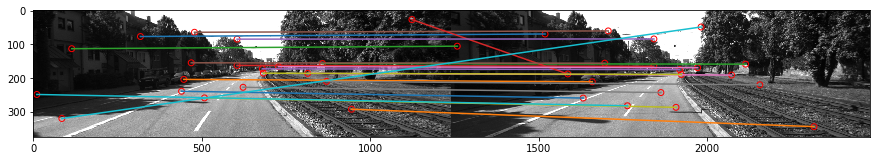

In [82]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import random


x1 = np.loadtxt("points1.txt").T
x2 = np.loadtxt("points2.txt").T
roadimgs = []
for i in range(2):
    img = io.imread('road' + str(i+1) + '.png')
    roadimgs.append(rgb2gray(img))

random_samples = np.random.choice(x1.shape[1], 20, replace=False)
x1 = x1[:,random_samples]
x2 = x2[:,random_samples]
matching = [(x1[:,i], x2[:,i]) for i in range(20)]    
show_matching_result(roadimgs[0],roadimgs[1], matching)

# Your code here

### Estimation of fundamental matrix using SIFT matches and plotting epipolar lines [3 pts]
Estimate the fundamental matrix using the SIFT matches. Plot the epipolar lines for 5 randomly selected keypoints. You may use *fundamental_matrix* and *plot_epipolar_lines* functions to do this. Note that it's normal to not get a correct result due to the noisy matching pairs.

(2, 390)
[ 1  0 13 10  5]


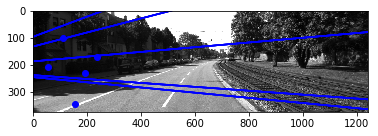

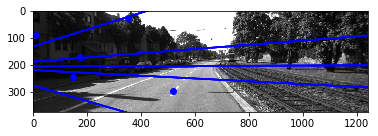

In [81]:
# Your code here
cor1 = np.loadtxt("points1.txt").T
cor2 = np.loadtxt("points2.txt").T
cor1_homog = to_homog(cor1)
cor2_homog = to_homog(cor2)
print(cor1.shape)
F_road = fundamental_matrix(cor1_homog,cor2_homog)
#choose random 5 points
random_samples = np.random.choice(20, 5, replace=False)
print(random_samples)
new_cor1 = cor1_homog[:,random_samples]
new_cor2 = cor2_homog[:,random_samples]
roadimgs = []
for i in range(2):
    img = io.imread('road' + str(i+1) + '.png')
    roadimgs.append(rgb2gray(img))

plot_epipolar_lines(F_road,roadimgs[0],roadimgs[1],new_cor1,new_cor2) 


### RANSAC with 8-point algorithm [10 pts]
Use RANSAC with the 8-point algorithm to remove outliers and re-estimate the fundamental matrix with the inliers. Visualize the inlier matches by drawing lines between the left and right images. Plot the epipolar lines for 5 randomly selected keypoints.

[  3   6  10  11  16  20  30  35  37  38  40  41  48  49  53  54  57  59
  60  63  65  66  67  78  79  81  82  83  91  99 100 101 103 104 106 108
 115 117 119 123 124 125 129 130 132 134 143 144 146 147 148 156 157 172
 176 178 188 189 193 197 200 201 202 204 206 213 216 217 219 221 223 226
 233 234 235 236 237 239 248 254 256 259 262 264 265 268 276 279 284 285
 302 304 307 308 313 330 331 332 335 336 338 339 341 347 348 349 354 357
 358 360 363 372 374 377 379 382 383 389]


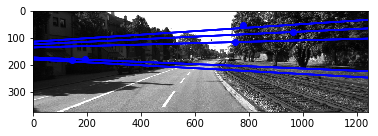

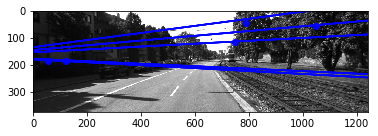

In [124]:
from tqdm import tqdm

def compute_fundamental_RANSAC(cor1, cor2, epiConstThres, nSample):
    """
    Input:
    - cor1, cor2: corners in image1 and image2
    - epiConstThres: Threshold for accepting inliers
    - nSample: number of iterations for RANSAC
    
    Output:
    - bestF: best fundamental matrix
    - bestInliersIdx: under bestF, the index of inliers of matching points
    - bestInliersNumList: record the best number of inliers so far at each iteration, with length nSample
    """
    """ YOUR CODE HERE !!!"""
    bestInliersNumList = []
    max = 0;
    #select eight random points, cor1 and cor2 will be passed as 2*390
    for iters in range(0, nSample):
        #this will contain the indices of the matching coordinates
        count_initial = 0
        bestInliersIdx_eachsample = []
        random_samples_ind = np.random.choice(cor1.shape[1], 8, replace=False)
        random_samples_cor1 = cor1[:,random_samples_ind]
        random_samples_cor2 = cor2[:,random_samples_ind]

        F = fundamental_matrix(random_samples_cor1,random_samples_cor2)
        for i in range(0,cor1.shape[1]):
            prod = np.dot((cor1[:,i].T),np.dot(F,cor2[:,i]))
            if(prod<epiConstThres):
                bestInliersIdx_eachsample.append(i) #it lies within the threshold
                count_initial = count_initial + 1
            
            
        if(count_initial>max):#checking for the no of matching points
            max = count_initial
            bestInliersIdx = (bestInliersIdx_eachsample)
        bestInliersNumList.append(max)
        
    #found the best set, now recomputing bestF
    inliers_cor1 = cor1[:,bestInliersIdx]
    inliers_cor2 = cor2[:,bestInliersIdx]
    bestInliersIdx_eachsample = []
    bestF = fundamental_matrix(inliers_cor1,inliers_cor2)
    for i in range(0,cor1.shape[1]):
        prod = np.dot((cor1[:,i].T),np.dot(bestF,cor2[:,i]))
        if(prod<epiConstThres):
            bestInliersIdx_eachsample.append(i) #it lies within the threshold
        
    bestInliersIdx = np.array(bestInliersIdx_eachsample,dtype=int)      
        
    
    return bestF, bestInliersIdx, bestInliersNumList

def fundamental_matrix_RANSAC(x1,x2, epiConstThres, nSample):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    bestF, bestInliersIdx, bestInliersNumList = compute_fundamental_RANSAC(x1,x2,epiConstThres,nSample)
    
    # reverse normalization
    bestF = np.dot(T1.T,np.dot(bestF,T2))

    return bestF/bestF[2,2], bestInliersIdx, bestInliersNumList

# calculating F using RANSAC
epiConstThres = 0.05
nSample = 3000
np.random.seed(10)

x1 = np.loadtxt("points1.txt").T
x2 = np.loadtxt("points2.txt").T
x1_h = to_homog(x1)
x2_h = to_homog(x2)
F, bestInliersIdx, bestInliersNumList = fundamental_matrix_RANSAC(x1_h, x2_h, epiConstThres, nSample)
print(bestInliersIdx)
inlierPts1 = x1_h[:,bestInliersIdx]
inlierPts2 = x2_h[:,bestInliersIdx]
chooseidx = np.random.choice(inlierPts1.shape[1], 5, replace=False)
plot_epipolar_lines(F, roadimgs[0], roadimgs[1], inlierPts1[:,chooseidx], inlierPts2[:,chooseidx])



Number of inliers as iteration increases:


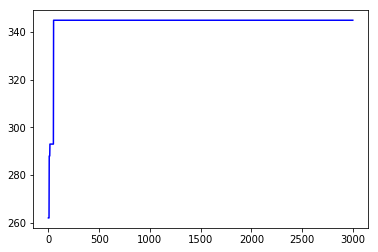

In [125]:
print('Number of inliers as iteration increases:')
plt.plot(np.arange(len(bestInliersNumList)), bestInliersNumList, 'b-')

### Conceptual question [2 pts]
Conceptually, can you guess approximately where the epipole should lie for the two images above? Explain your reasoning. Do your epipolar lines above match that intuition? 

Your answer here.

---
## Submission Instructions
Remember to submit a PDF version of this notebook to Gradescope. Please make sure the contents in each cell are clearly shown in your final PDF file.

There are multiple options for converting the notebook to PDF:
1. You can find the export option at File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX
2. You can first export as HTML and then convert to PDF